In [1]:
# !python -m spacy download en_core_web_md
# !pip install scikit-plot
# !pip install livelossplot
# !pip install gradio
# !pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from pandas.core.common import random_state
import random

import en_core_web_md
import nltk
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

import scikitplot as skplt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, SimpleRNN, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from livelossplot import PlotLossesKeras

import gradio as gr



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/content/drive/MyDrive/df_for_classification.csv')

In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   section              1210 non-null   object 
 1   byline               1210 non-null   object 
 2   title                1210 non-null   object 
 3   abstract             1210 non-null   object 
 4   class                1210 non-null   object 
 5   print_page           1210 non-null   float64
 6   pub_date             1072 non-null   object 
 7   type_of_material     1072 non-null   object 
 8   class_le             1210 non-null   int64  
 9   byline_le            1210 non-null   float64
 10  section_le           1210 non-null   float64
 11  type_of_material_le  1210 non-null   float64
 12  title_clean          1210 non-null   object 
 13  abstract_clean       1210 non-null   object 
 14  title_vec_avg        1210 non-null   float64
 15  abstract_vec_avg     1210 non-null   f

#Model building

In [6]:
def get_feats(df, black_list=['class_le', 'index']):
    return [x for x in df.select_dtypes(['number', 'bool']).columns if x not in black_list]

def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)
        
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(df[feats].values)
    le_y = preprocessing.LabelEncoder()
    y=le_y.fit_transform(df['class'].values)
    
    return X, y

X, y = get_X_y(df)

def model_train_predict(model, X, y, test_size=0.3):
    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
    
    cv = KFold(n_splits=3, random_state=2021, shuffle=True)
    scores=[]
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        
    score = accuracy_score(y[test_idx], y_pred)
    scores.append(score)
    
    return score, y_pred, cv

In [7]:
def run_cv_model(model_cls, model_params, X, y, feats, cv=KFold(n_splits=5, random_state=2021, shuffle=True), scoring='f1',
                 plot_learning_curve=True, plot_confusion_matrix=True, plot_feature_importances=True):

    scores = cross_val_score(model_cls(**model_params), X, y, cv=cv, scoring=scoring)
    print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 2), np.round(np.std(scores), 2), scores))
    
    model = None
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X, y)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X, y, title=title,figsize=(15, 5), cv=cv, scoring=scoring);
    
    if plot_confusion_matrix:
        y_pred = cross_val_predict(model_cls(**model_params), X, y, cv=cv)
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y, y_pred, title=title, normalize=True, figsize=(20 ,10))
    
    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X, y)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));    


mean=0.68, std=0.07, scores=[0.62222222 0.74418605 0.57534247 0.7032967  0.73469388]


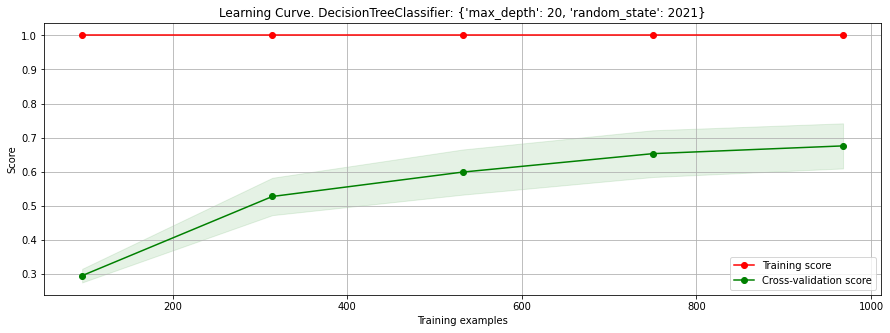

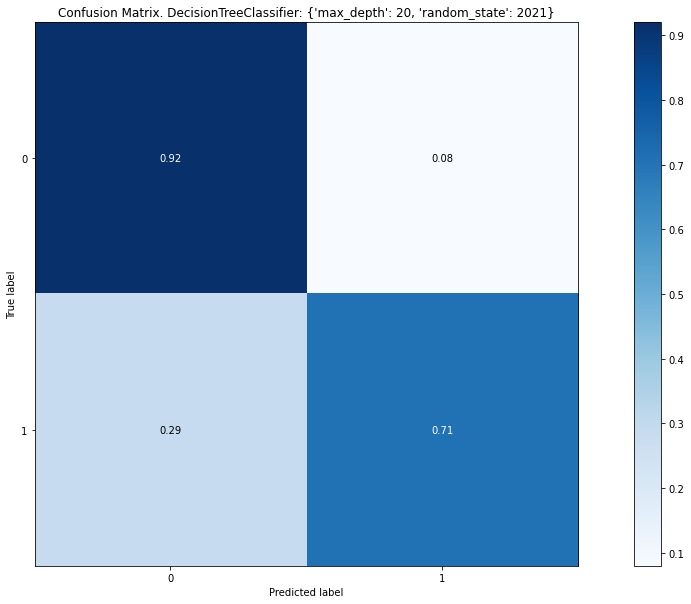

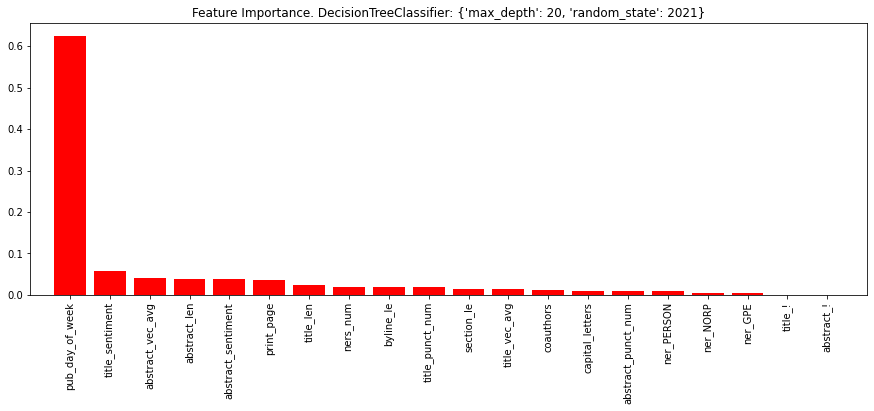

In [8]:
run_cv_model(DecisionTreeClassifier, {'max_depth':20, 'random_state':2021}, X,y, get_feats(df))

mean=0.78, std=0.05, scores=[0.76470588 0.83333333 0.68965517 0.8        0.83116883]


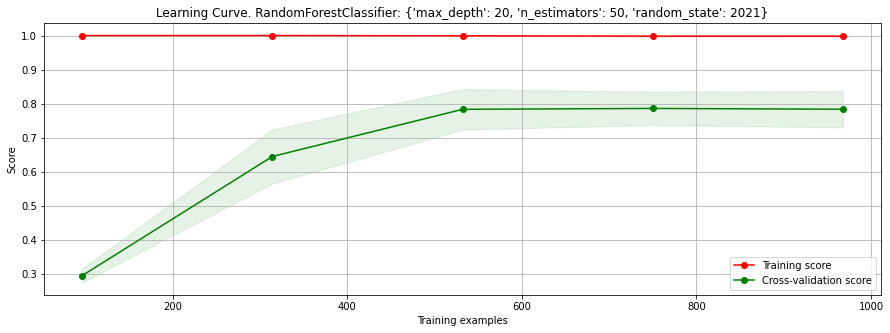

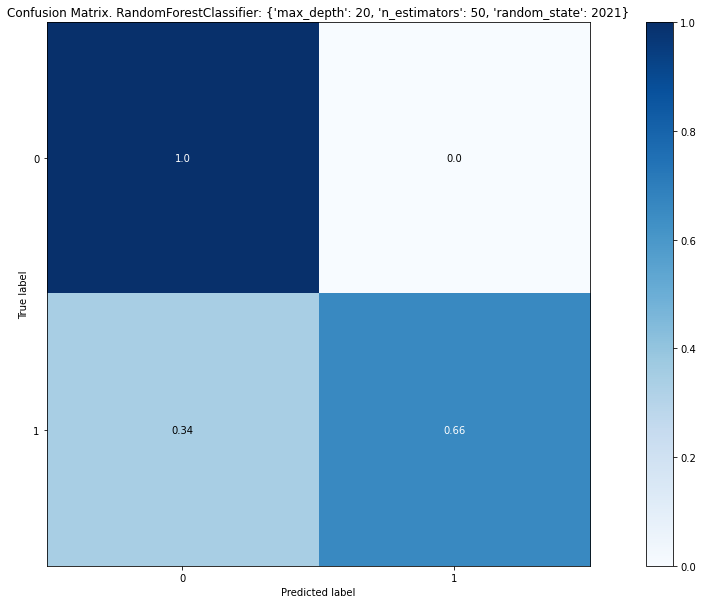

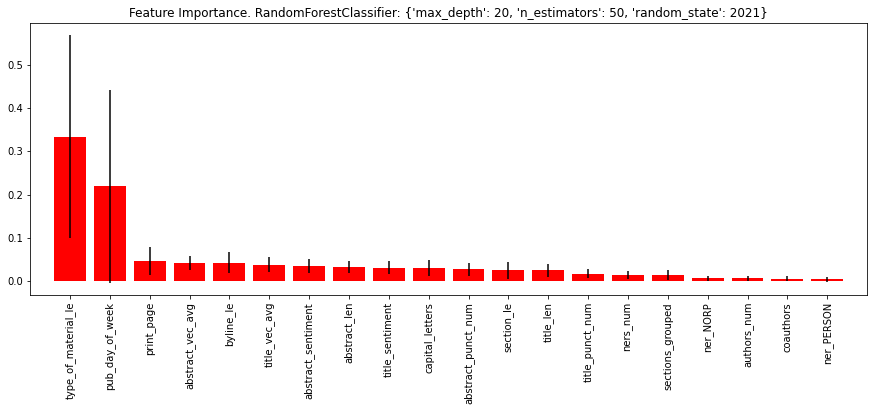

In [9]:
run_cv_model(RandomForestClassifier, {'max_depth':20, 'n_estimators':50, 'random_state':2021}, X,y, get_feats(df))

mean=0.77, std=0.05, scores=[0.74285714 0.78947368 0.6779661  0.81578947 0.8       ]


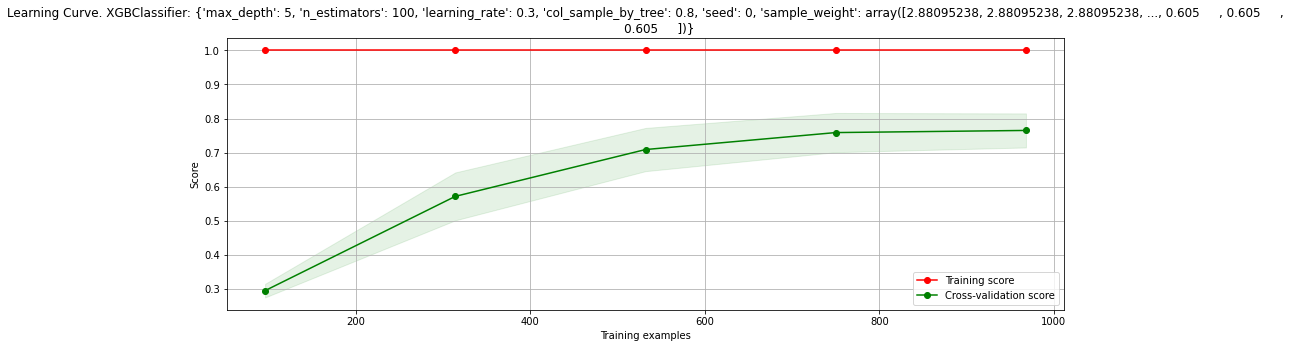

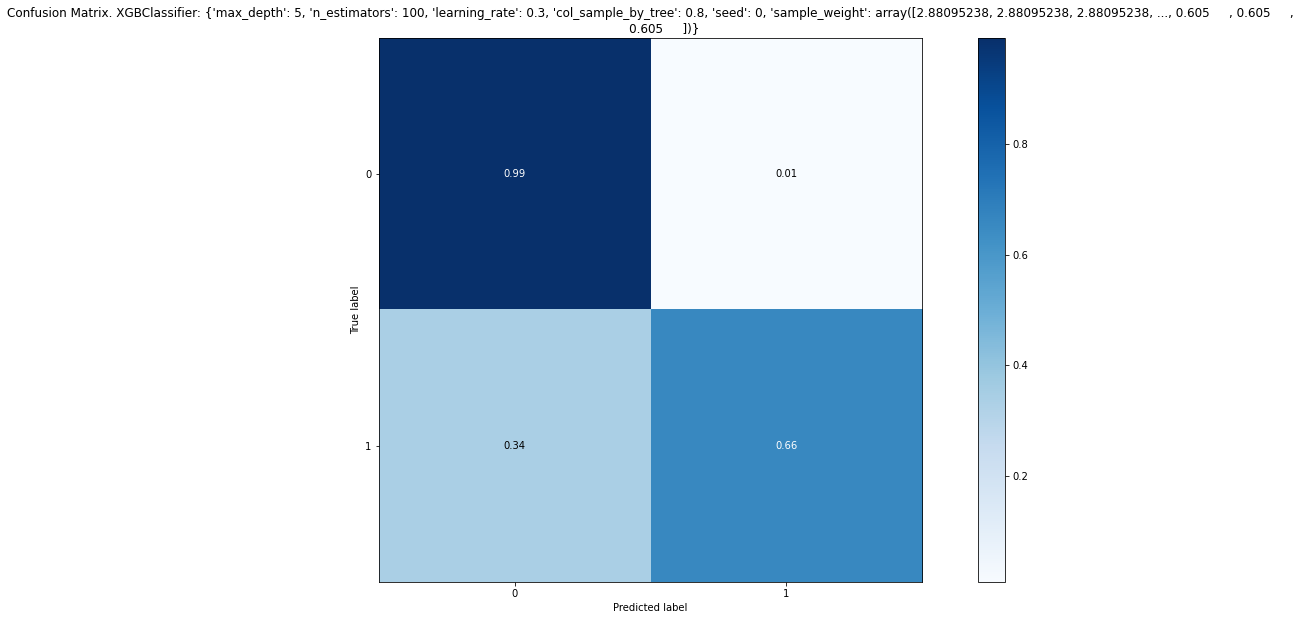

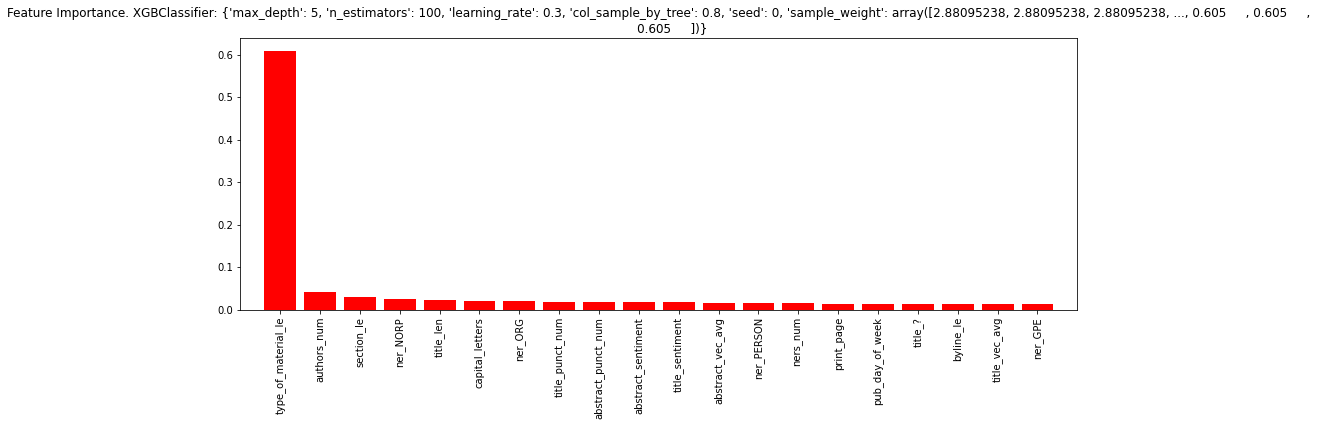

In [10]:
run_cv_model(xgb.XGBClassifier, {'max_depth':5, 'n_estimators':100, 'learning_rate':0.3, 'col_sample_by_tree':0.8, 'seed':0, 'sample_weight':compute_sample_weight("balanced", y)}, X,y, get_feats(df))

In [11]:
def run_cv_model_wo_feats(model_cls, model_params, X, y, feats, cv=KFold(n_splits=5, random_state=2021, shuffle=True), scoring='f1',
                 plot_learning_curve=True, plot_confusion_matrix=True, plot_feature_importances=True):

    scores = cross_val_score(model_cls(**model_params), X, y, cv=cv, scoring=scoring)
    print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 2), np.round(np.std(scores), 2), scores))
    
    model = None
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X, y)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X, y, title=title,figsize=(15, 5), cv=cv, scoring=scoring);
    
    if plot_confusion_matrix:
        y_pred = cross_val_predict(model_cls(**model_params), X, y, cv=cv)
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y, y_pred, title=title, normalize=True, figsize=(20 ,10))

mean=0.71, std=0.09, scores=[0.7012987  0.76923077 0.525      0.78571429 0.74725275]


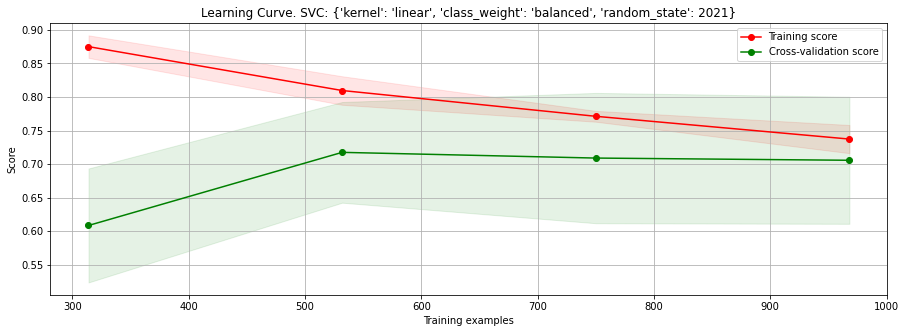

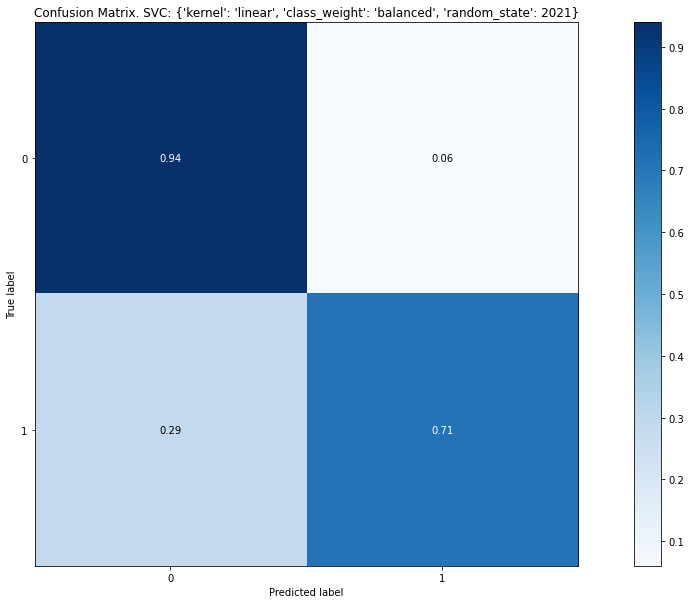

In [12]:
run_cv_model_wo_feats(svm.SVC, {'kernel': 'linear', 'class_weight': 'balanced', 'random_state':2021}, X, df['class_le'], get_feats(df))

#Optimization of model parameters

In [13]:
def objective(space):
    
    DTC_params = {
        'max_depth': int(space['max_depth']),
        'min_weight_fraction_leaf': int(space['min_weight_fraction_leaf']),
        'max_features': int(space['max_features']),
        'max_leaf_nodes': int(space['max_leaf_nodes'])
    }
        
    model = DecisionTreeClassifier(**DTC_params, random_state=2021)
    cv = KFold(n_splits=5, random_state=2021, shuffle=True)
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        score = f1_score(y[test_idx], y_pred)
    
    return{'loss': -score, 'status': STATUS_OK}
    
space ={
    'max_depth': hp.quniform ('max_depth', 5, 20, 1),
    'random_state': hp.quniform ('random_state', 0, 10000, 50),
    'min_weight_fraction_leaf': hp.quniform ('min_weight_fraction_leaf', 0, 0.9, 0.1),
    'max_features': hp.quniform ('max_features', 1, 9, 1),
    'max_leaf_nodes': hp.quniform ('max_leaf_nodes', 2, 100, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [00:00<00:00, 32.55it/s, best loss: -0.846153846153846]
The best params:  {'max_depth': 5.0, 'max_features': 4.0, 'max_leaf_nodes': 79.0, 'min_weight_fraction_leaf': 0.9, 'random_state': 3500.0}


mean=0.78, std=0.06, scores=[0.76056338 0.82191781 0.6779661  0.8        0.83116883]


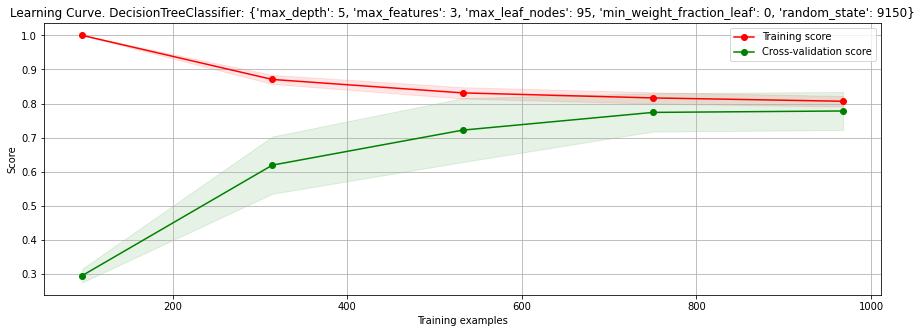

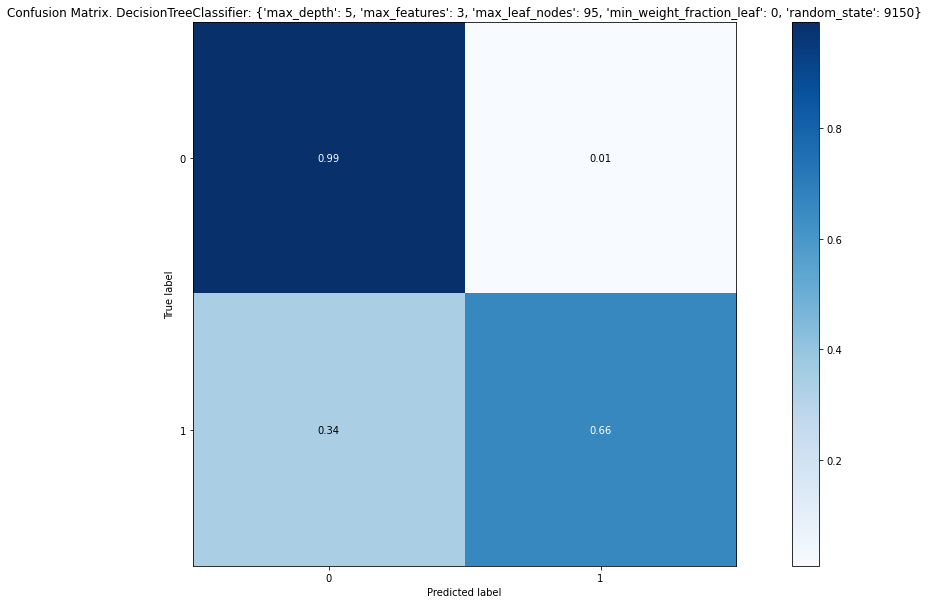

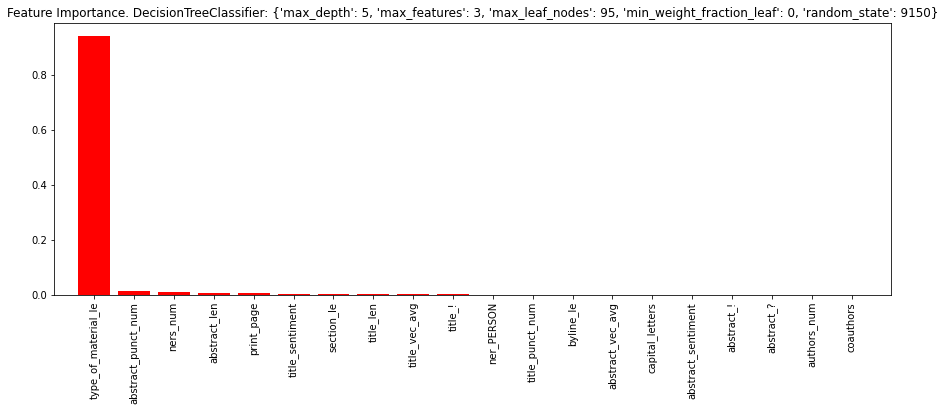

In [14]:
run_cv_model(DecisionTreeClassifier, {'max_depth': 5, 'max_features': 3, 'max_leaf_nodes': 95, 'min_weight_fraction_leaf': 0, 'random_state': 9150}, X,y, get_feats(df))

#Model deployment

> Support Vector Classification



In [15]:
def get_feats(df, black_list=['class_le']):
    return [x for x in df.select_dtypes(['number', 'bool']).columns if x not in black_list]

def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)
        
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(df[feats].values)
    y=df['class'].values
    
    return X, y, scaler

X, y, scaler = get_X_y(df)

def model_train_predict(model, X, y, test_size=0.3):
    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
    
    cv = KFold(n_splits=5, random_state=2021, shuffle=True)
    scores=[]
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        
    score = f1_score(y[test_idx], y_pred)
    scores.append(score)
    
    return score, y_pred, cv


In [16]:
def cap_lett(message):
  n=0
  for x in message:
    if x.isupper():
      n += 1
  return n

def is_coauthor(authors_num):
  if authors_num > 1: 
    coauthors = 1
  else: 
    coauthors = 0
  return coauthors

def group_sections(section): 
    if section in ('Sports', 'Books', 'Movies', 'Crosswords & Games', 'Theater', 'Arts'):   #entertainment
      return 1
    elif section in ('Health', 'Style', 'Food', 'Well', 'Travel', 'Fashion & Style', 'Home & Garden', 'T Magazine'): #lifestyle
      return 2 
    elif section in ('Technology', 'Climate', 'Science', 'Education'): #knowlegde
      return 3
    elif section in ('Business', 'You Money', 'Real Estate', 'Business Day', 'Briefing'): #business
      return 4 
    elif section == 'World':
      return 5
    elif section in ('U.S.', 'New York'):
      return 6
    return 7            #others

def ners_GPE(x):
  if len(x) > 0 :
    for i in x:
      if i == 'GPE':
        return 1
      return 0
  else:
    return 0

def ners_PERSON(x):
  if len(x) > 0 :
    for i in x:
      if i == 'PERSON':
        return 1
      return 0
  else:
    return 0

def ners_ORG(x):
  if len(x) > 0 :
    for i in x:
      if i == 'ORG':
        return 1
      return 0
  else:
    return 0

def ners_MONEY(x):
  if len(x) > 0 :
    for i in x:
      if i == 'MONEY':
        return 1
      return 0
  else:
    return 0

def ners_NORP(x):
  if len(x) > 0 :
    for i in x:
      if i == 'NORP':
        return 1
      return 0
  else:
    return 0

le_byline = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
df['byline_le'] = le_byline.fit_transform(df['byline'].values.reshape(-1,1))
le_section = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
df['section_le'] = le_section.fit_transform(df['section'].values.reshape(-1,1))
le_material = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
df['type_of_material_le'] = le_material.fit_transform(df['type_of_material'].values.reshape(-1,1))
df['type_of_material_le'] = df['type_of_material_le'].fillna(-2)
nlp=en_core_web_md.load()
sent = SentimentIntensityAnalyzer()

In [17]:
def model_gradio(Section, Byline, Title, Abstract, Print_Page, Type_of_material, Publication_date):
  byline_g = le_byline.transform(np.array(Byline).reshape(-1, 1)).item(0)
  title_clean_g = ' '.join([word for word in Title.lower().split() if word not in stopwords])  
  abstract_clean_g = ' '.join([word for word in Abstract.lower().split() if word not in stopwords])
  abstract_vec = np.mean(nlp(abstract_clean_g).vector)
  title_vec = np.mean(nlp(title_clean_g).vector)
  section_g = le_section.transform(np.array(Section).reshape(-1,1)).item(0)
  type_of_material_g = le_material.transform(np.array(Type_of_material).reshape(-1,1)).item(0)
  title_len = len(Title.split())
  abstract_len = len(Abstract.split())
  capital_letters = cap_lett(Title)
  title_punct_num = len([word for word in Title if word in string.punctuation])
  abstract_punct_num = len([word for word in Abstract if word in string.punctuation])
  title_exclamation = len([word for word in Title if word == "!"])
  title_question = len([word for word in Title if word == "?"])
  abstract_exclamation = len([word for word in Abstract if word == "!"])
  abstract_question = len([word for word in Abstract if word == "?"])
  authors_num = len([word for word in Byline if word == "," or word == 'and' or word == '&'])+1
  coauthors = is_coauthor(authors_num)
  sections_grouped = group_sections(Section)
  title_ner = nlp(Title).ents
  title_ner_type = [en.label_ for en in title_ner]
  title_ner_num = len(title_ner_type)
  ner_GPE = ners_GPE(title_ner_type)
  ner_PERSON = ners_PERSON(title_ner_type)
  ner_ORG = ners_ORG(title_ner_type)
  ner_MONEY = ners_MONEY(title_ner_type)
  ner_NORP = ners_NORP(title_ner_type)
  pub_date = pd.to_datetime(Publication_date)
  pub_day_of_week = pub_date.day_of_week
  title_sentiment = sent.polarity_scores(Title)['compound']
  abstract_sentiment = sent.polarity_scores(Abstract)['compound']
  print_page = Print_Page

  test_x = np.array([print_page, byline_g, section_g, type_of_material_g, title_vec, abstract_vec, title_len, abstract_len,
                    capital_letters, title_punct_num,  abstract_punct_num, title_exclamation, abstract_exclamation, title_question, abstract_question,
                     authors_num, coauthors, sections_grouped, title_ner_num, ner_GPE, ner_PERSON, ner_ORG, ner_MONEY, ner_NORP, 
                     pub_day_of_week, title_sentiment, abstract_sentiment])
  xscaled = scaler.transform(test_x.reshape(1,-1))
  params = {'kernel': 'linear', 'class_weight': 'balanced', 'random_state':2021}
  model = cls = SVC(**params) 
  model.fit(X, y)
  prediction = model.predict(xscaled).item(0)
  if prediction == 'top':
    prediction = 'yes 🥳'
  else:
    prediction = 'no 🙁'
  return prediction

In [18]:
get_feats(df)

['print_page',
 'byline_le',
 'section_le',
 'type_of_material_le',
 'title_vec_avg',
 'abstract_vec_avg',
 'title_len',
 'abstract_len',
 'capital_letters',
 'title_punct_num',
 'abstract_punct_num',
 'title_!',
 'abstract_!',
 'title_?',
 'abstract_?',
 'authors_num',
 'coauthors',
 'sections_grouped',
 'ners_num',
 'ner_GPE',
 'ner_PERSON',
 'ner_ORG',
 'ner_MONEY',
 'ner_NORP',
 'pub_day_of_week',
 'title_sentiment',
 'abstract_sentiment']

In [19]:
model_gradio("U.S.",'David E. Sanger, Julian E. Barnes and Kate Conger',  'As Tanks Rolled Into Ukraine, So Did Malware. Then Microsoft Entered the War.', 'After years of talks about the need for public-private partnerships to combat cyberattacks, the war in Ukraine is stress-testing the system.', 11,'News','2022-03-01')

'yes 🥳'

In [20]:
model_gradio("U.S.",'Katharine Q. Seelye',  'Lynn Yeakel, Spurred Into Politics by Anita Hill, Dies at 80', 'She nearly unseated Senator Arlen Specter after his aggressive grilling of Ms. Hill during Clarence Thomas’s 1991 Supreme Court confirmation hearings.', 20,'Obituary (Obit)','2022-03-17')

'no 🙁'

In [21]:
demo = gr.Interface(
    fn=model_gradio,
    inputs=[gr.Radio(['Arts', 'Automobiles', 'Books', 'Briefing', 'Business', 'Business Day', 'Climate', 'Crosswords & Games', 'Education','Fashion & Style', 'Food', 'Health',
       'Home & Garden', 'International Home', 'Magazine', 'Movies', 'New York', 'Obituaries', 'Opinion', 'Reader Center','Real Estate', 'Science', 'Special Series',
       'Sports', 'Style', 'Sunday Review','T Magazine', 'Technology', 'The Upshot','Theater', 'Times Insider', 'Travel','U.S.', 'Well', 'World', 'Your Money']), #section
       'text', #byline
       'text', #title
       'text', #abstract
       'number', #print page
       gr.Radio(['News', 'Op-Ed', 'Obituary (Obit)', 'Editorial', 'Review',
       'briefing', 'Letter', 'List', 'News Analysis']), #type of material
       'text' #publication date
       ],
    outputs='text',
    title='Is this article top shared?'
)

demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://10582.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f5474b7f710>,
 'http://127.0.0.1:7860/',
 'https://10582.gradio.app')

#RECURSIVE NETWORK

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, df['class_le'], test_size=0.3, random_state=2)
n_features = X.shape[1]
n_classes = 2
print('X_train shape: ', X_train.shape) 
print('n_features: ', n_features) 
print('n_classes: ', n_classes) 

X_train shape:  (847, 27)
n_features:  27
n_classes:  2


In [23]:
model = models.Sequential()
model.add(layers.Dense(1, input_dim=n_features, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

In [24]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 28        
                                                                 
 dense_1 (Dense)             (None, 2)                 4         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


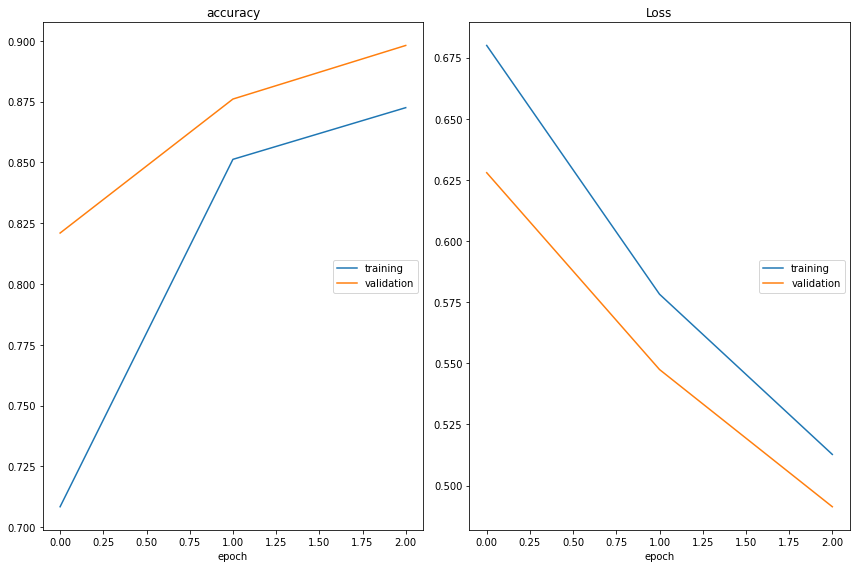

accuracy
	training         	 (min:    0.708, max:    0.872, cur:    0.872)
	validation       	 (min:    0.821, max:    0.898, cur:    0.898)
Loss
	training         	 (min:    0.513, max:    0.680, cur:    0.513)
	validation       	 (min:    0.491, max:    0.628, cur:    0.491)
170/170 [==============================] - 1s 4ms/step - loss: 0.5127 - accuracy: 0.8725 - val_loss: 0.4913 - val_accuracy: 0.8981


In [25]:
model.fit(X_train, Y_train, batch_size=5, epochs=3, verbose=1, validation_data=(X_test, Y_test), callbacks=[PlotLossesKeras()])

In [26]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.49133333563804626
Test accuracy:  0.8980716466903687
